In [1]:
from clustering import Clustering,Trajectory
from utils import refactor_and_plot,display_clusters_oat
import time
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import cv2
from color import colors

from numpy.linalg import inv

from scipy.spatial.distance import euclidean,cityblock,squareform
from scipy.cluster.hierarchy import dendrogram, linkage, ward, fcluster,cophenet

from fastdtw import fastdtw

from sklearn.cluster import DBSCAN, AgglomerativeClustering, AffinityPropagation, SpectralClustering
import scipy.spatial.distance as ssd

In [2]:
c = Clustering("laurier/laurier.sqlite","laurier/laurier-homography.txt")
c.get_trajectories(pixels = 1)
trajectories = [trajectory.pixel_trajectory for trajectory in c.trajectories]


### behavior feature extraction

In [3]:
def compute_velocity(x1,x2,delta_t = 1):#pixel per frame
     #1 frame
    return np.sign(x2[0]-x1[0]) * euclidean(x1,x2) / delta_t
def compute_ROT(x1,x2):#rate of turn
    return np.arctan((x2[1]-x1[1])/(x2[0]-x1[0]))

In [4]:
def compute_velocities(trajectory):
    velocity = np.zeros(len(trajectory))
    for i in range(1,len(trajectory)):
        velocity[i] = compute_velocity(trajectory[i-1],trajectory[i])
    velocity[0] = velocity[1]
    return velocity

def compute_ROTS(trajectory):
    rot = np.zeros(len(trajectory))
    for i in range(1,len(trajectory)):
        rot[i] = compute_ROT(trajectory[i-1],trajectory[i])
    return rot

In [5]:
#trajectories = np.array(trajectories).reshape(1792,1)
trajectories_x = [[e[0] for e in trajectory] for trajectory in trajectories ]
trajectories_y = [[e[1] for e in trajectory] for trajectory in trajectories ]
velocities = [compute_velocities(trajectory) for trajectory in trajectories]
rots = [compute_ROTS(trajectory) for trajectory in trajectories]

In [6]:
def get_difference(arr):
    results = []
    for e in arr:
        t = []
        for i in range(1,len(e)):
            #print(arr[i],arr[i-1])
            t.append(e[i]-e[i-1])
        results.append(t)
    return results

In [7]:
diff_x = get_difference(trajectories_x)
diff_y = get_difference(trajectories_y)
diff_v = get_difference(velocities)
diff_r = get_difference(rots)

In [8]:
#duration is the length of the trajectory sample
# return array of indexes
def sliding_windows(duration, window_size = 10):
    offset = window_size/2
    nb_results = int(duration/offset)
    windows = []
    for i in range(nb_results):
        windows.append([])
        
    for i in range(0,duration):
        for j in range(nb_results):
            if j*offset <= i and i < j*offset + window_size:
                windows[j].append(i)
    return windows


In [9]:
def behavior_feature_extraction(diff_x,diff_y,diff_v,diff_r):
    Btr = []
    windows = sliding_windows(len(diff_x))
    for window in windows:
        if len(window) > 0:
            Fw = []
            #print(len(window))
            for i in range(len(window)):
                k = window[i]
                Fw.append([diff_x[k],diff_y[k],diff_v[k],diff_r[k]])
            df = pd.DataFrame(Fw)
            ddf = df.describe().drop(['count','std']).values.flatten()

            Btr.append(ddf)
    return Btr

In [10]:
start = time.time()
A = [behavior_feature_extraction(diff_x[i],diff_y[i],diff_v[i],diff_r[i]) for i in range(len(diff_x))]
end = time.time() - start

In [11]:
print(end)

99.2541821003


In [12]:
flatten_A = np.array([box for trajectory in A for box in trajectory])

In [13]:
print(flatten_A.shape)

(12361, 24)


### MinMax scaling (gives better results)

In [14]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
s = min_max_scaler.fit_transform(flatten_A)

### Standardization 

In [14]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
s = std_scaler.fit_transform(flatten_A)

In [15]:
B = []
counter = 0
for i in range(len(A)):
    t = []
    for j in range(len(A[i])):
        t.append(s[counter])
        counter += 1
    B.append(t)

In [16]:
def append_eos(trajectories, input_size = 24):
    #padd = np.zeros((24))
    EOS = np.full((24),0)
    for t in trajectories:
        t.append(EOS)
    return trajectories

In [17]:
import copy

#B = copy.deepcopy(A)
X = append_eos(B)

### Autoencoder

In [18]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        #self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(input_size, hidden_size)

    def forward(self, input_, hidden):
        #embedded = self.embedding(input).view(1, 1, -1)
        #output = embedded
        output = input_

        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        #self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(output_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_, hidden):
        #output = self.embedding(input).view(1, 1, -1)
        #output = F.relu(output)
        output = input_
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        #output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self, h):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [21]:
import random

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    
    # initialize hidden state for the encoder
    encoder_hidden = encoder.initHidden()
    
    # set gradients to zero for both optimizer
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    encoder_outputs,encoder_hidden = encoder.forward(input_tensor,encoder_hidden)
    
     
    SOS = torch.tensor(np.ones((output_size)),dtype = torch.float).view(1,1,output_size)
    EOS = torch.tensor(np.full((24),0),dtype = torch.float).view(1,1,output_size)
    
    decoder_hidden = encoder_hidden
    

    loss = 0
    
    decoder_output,decoder_hidden = decoder.forward(SOS,decoder_hidden)
    loss += criterion(decoder_output, target_tensor[0].view(1,1,output_size) )
    
    
    #while euclidean(EOS,decoder_output) > 1:
    for i in range(1,target_tensor.size(0)):
        if random.uniform(0, 1) < teacher_forcing_ratio:
            decoder_output = target_tensor[i-1].view(1,1,output_size)

        decoder_output,decoder_hidden = decoder.forward(decoder_output,decoder_hidden)

        loss += criterion(decoder_output, target_tensor[i].view(1,1,output_size) )
    
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()/target_tensor.size(0)
    
    
    

In [22]:
import time
def trainIters(encoder, decoder, X_train,X_test, n_iters, print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    times = []
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    plot_losses_eval = []

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.MSELoss()

    for iter in range(1, n_iters + 1):
        x = random.choice(X_train)
        
        input_tensor = torch.tensor(x,dtype=torch.float).view([len(x),batch_size,input_size])
        target_tensor = copy.deepcopy(input_tensor)

        loss = train(input_tensor, target_tensor, encoder,decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            times.append((time.time()-start,print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            loss_eval = 0
            for t in X_test:
                t = torch.tensor(t,dtype=torch.float).view([len(t),batch_size,input_size])
                loss_eval += evaluate(encoder, decoder, t)
            plot_losses_eval.append(loss_eval / len(X_test))
            plot_loss_total = 0
            
    plt.plot(plot_losses)
    plt.plot(plot_losses_eval,color='r')
    plt.show()
    print(times)

In [23]:
from scipy.spatial.distance import euclidean

def evaluate(encoder, decoder, input_tensor, threshold = 0.1):
#def evaluate(encoder, decoder,criterion, input_tensor, threshold, max_length=MAX_LENGTH ):

    with torch.no_grad():
        
        encoder_hidden = encoder.initHidden()
        encoder_outputs,encoder_hidden = encoder.forward(input_tensor,encoder_hidden)

        
        SOS = torch.tensor(np.ones((output_size)),dtype = torch.float).view(1,1,output_size)
        c = nn.MSELoss()

        decoder_hidden = encoder_hidden
        
        outputs = []

        decoder_output,decoder_hidden = decoder.forward(SOS,decoder_hidden)
        outputs.append(decoder_output)
        loss = 0
        for i in range(input_tensor.size(0)):
            #dist = euclidean(decoder_output,EOS)
            #if dist <= threshold:
            #    break
            decoder_output,decoder_hidden = decoder.forward(decoder_output,decoder_hidden)
            loss += c(decoder_output, input_tensor[i].view(1,1,output_size) )
            #outputs.append(decoder_output)

    
    return loss

In [24]:
teacher_forcing_ratio = 0

batch_size = 1
input_size = 6*4
output_size = 6*4
hidden_size = 100

encoder = EncoderRNN(input_size,hidden_size)
decoder = DecoderRNN(hidden_size,output_size)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X)


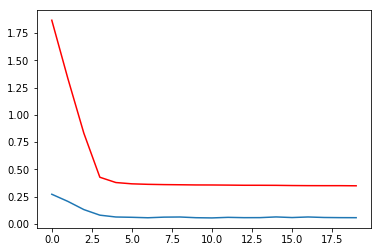

[(15.353116035461426, 0.10424815398395222), (32.85594201087952, 0.057847680718079775)]
33.9134302139


In [26]:
start = time.time()
trainIters(encoder, decoder, X_train = X_train,X_test = X_test, n_iters = 2000, print_every=1000, plot_every=100, learning_rate=0.001)
end = time.time()-start
print(end)

In [27]:
def unify_trajectory_sizes(encoder,X):
    D = []
    for x in X:        
        input_tensor = torch.tensor(x,dtype=torch.float).view([len(x),batch_size,input_size])

        encoder_hidden = encoder.initHidden()
        _,encoder_hidden = encoder.forward(input_tensor,encoder_hidden)
        D.append(encoder_hidden.detach().numpy()[0][0])
    D = np.array(D)
    return D

In [28]:
D = unify_trajectory_sizes(encoder,X)
np.savetxt("unified_trajectory_seq2seq.txt",D)

In [29]:
print(D.shape)

(1792, 100)


### Clustering

In [41]:
D = np.loadtxt("unified_trajectory_seq2seq.txt")

In [30]:
import pandas as pd
df = pd.DataFrame(D)

In [31]:
from sklearn.preprocessing import StandardScaler

std_data = copy.copy(df)
scaler = StandardScaler()
std_data[std_data.columns] = scaler.fit_transform(std_data[std_data.columns]) 

### KMeans

In [32]:
from sklearn.cluster import KMeans

nb_clusters = 6 #nb pair pour l'affichage
clusters = KMeans(n_clusters=nb_clusters, random_state=0).fit_predict(std_data)

### DBSCAN

In [59]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.5, min_samples=5).fit_predict(std_data)

In [62]:
print(np.max(clusters))
count = 0
for j in clusters:
    if j == -1:
        count += 1
print(count)

14
1680


### Hierarchical

In [67]:
from sklearn.cluster import AgglomerativeClustering

clusters = AgglomerativeClustering(n_clusters=nb_clusters).fit_predict(std_data) # ou D

### Display one after the other

#### out window

In [36]:
from utils import refactor_and_plot,display_clusters_oat

display_clusters_oat(clusters,"laurier/laurier.avi",[trajectory.pixel_trajectory for trajectory in c.trajectories])

#### in window

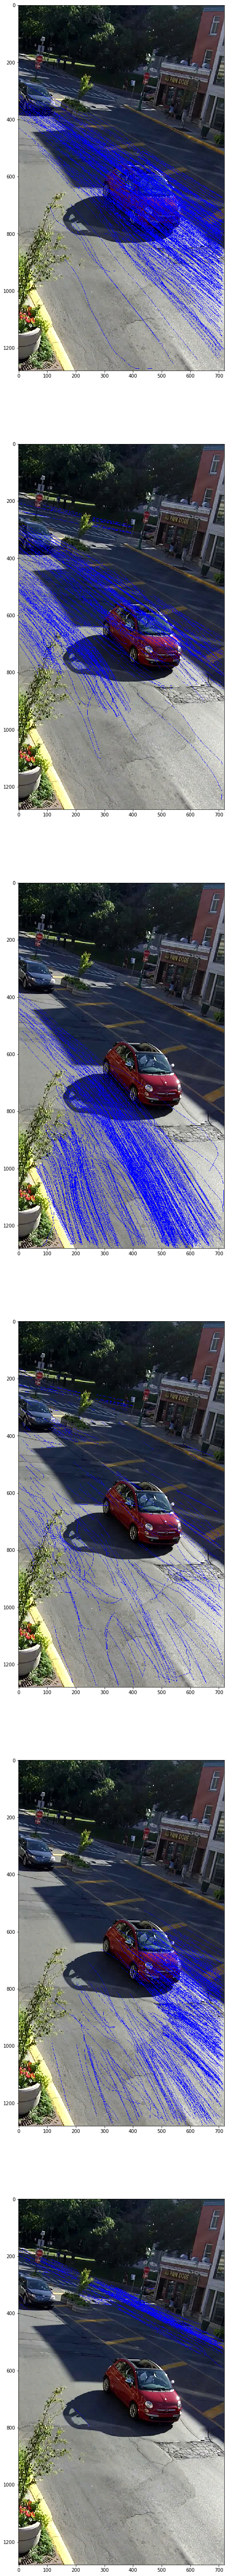

In [34]:
import matplotlib.image as mpimg

import copy

img = mpimg.imread("laurier/laurier.jpg")
fig = plt.figure(figsize=(10,100))

columns = 1
rows = nb_clusters

for i in range(nb_clusters):
    fig.add_subplot(rows,columns,i+1)
    img1 = copy.copy(img)
    for j,cl in enumerate(clusters):
        if cl == i:
            #img = mpimg.imread("laurier/laurier.jpg")
            
            pts = np.array(c.trajectories[j].pixel_trajectory , np.int32)
            pts = pts.reshape((-1,1,2))
            img1 = cv2.polylines(img1,[pts],False,(0,0,255)) 
    plt.imshow(img1)

plt.show()

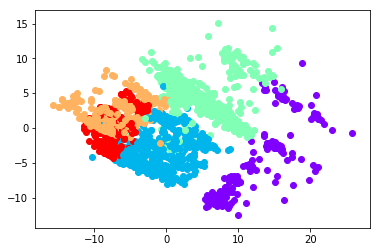

In [69]:
import matplotlib.cm as cm
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(std_data)
ddf = pd.DataFrame(principalComponents)
colors = cm.rainbow(np.linspace(0, 1, nb_clusters))


for i, row in ddf.iterrows():
    plt.scatter(row[0], row[1], color = colors[clusters[i]])
plt.show()

In [35]:
from utils import refactor_and_plot,display_clusters_oat
display_clusters_oat(clusters,"laurier/laurier.avi",[trajectory.pixel_trajectory for trajectory in c.trajectories])